In [1]:
# Import the required libraries for data handling, visualization, and accuracy evaluation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

# Set visual theme for clean plots
sns.set(style="whitegrid")

In [2]:
# Load all datasets related to NZ retail and inventory analysis
retail_trade = pd.read_csv("Retail_Trade_Sales_and_stocks_by_industry_1995_Q32025_Q1.csv")
inventory_opt = pd.read_csv("nz_retail_inventory_optimized.csv")
forecast_model = pd.read_csv("Forecast_Model.csv")
regional_sales = pd.read_csv("Regional_Sales.csv")
aes = pd.read_csv("Annual_Enterprise_Survey_2023.csv")
cpi = pd.read_csv("CPI.csv")
wholesale = pd.read_csv("Wholesale.csv")
inventory = pd.read_csv("Inventory.csv")
forecast = pd.read_csv("Forecast.csv")
retail_sales = pd.read_csv("Retail_Sales.csv")

In [3]:
# Clean retail_trade dataset to focus only on retail industries and convert quarter to date
retail_trade_clean = retail_trade.copy()
retail_trade_clean = retail_trade_clean[retail_trade_clean['Industry'].str.contains("Retail", case=False, na=False)]
retail_trade_clean = retail_trade_clean.dropna(subset=['Value'])
retail_trade_clean['Quarter'] = retail_trade_clean['Quarter'].str.replace(" Q1", "-03-31")\
                                                             .str.replace(" Q2", "-06-30")\
                                                             .str.replace(" Q3", "-09-30")\
                                                             .str.replace(" Q4", "-12-31")
retail_trade_clean['Quarter'] = pd.to_datetime(retail_trade_clean['Quarter'], errors='coerce')

# Clean regional_sales: drop nulls and convert to datetime
regional_sales_clean = regional_sales.dropna(subset=['Value'])
regional_sales_clean['Quarter'] = regional_sales_clean['Quarter'].str.replace(" Q1", "-03-31")\
                                                                 .str.replace(" Q2", "-06-30")\
                                                                 .str.replace(" Q3", "-09-30")\
                                                                 .str.replace(" Q4", "-12-31")
regional_sales_clean['Quarter'] = pd.to_datetime(regional_sales_clean['Quarter'], errors='coerce')

In [4]:
# Convert forecast and inventory quarters to datetime for later merging
forecast['Quarter'] = pd.to_datetime(forecast['Quarter'], errors='coerce')
inventory['Quarter'] = pd.to_datetime(inventory['Quarter'], errors='coerce')

# Merge forecast and inventory datasets to evaluate demand planning alignment
forecast_inventory = forecast.merge(inventory, on='Quarter', how='left')

# Convert time columns to datetime for retail_sales and cpi
retail_sales['Quarter'] = pd.to_datetime(retail_sales['Quarter'], errors='coerce')
cpi['Quarter'] = pd.to_datetime(cpi['Quarter'], errors='coerce')
cpi = cpi.dropna(subset=['CPI_Index'])

# Filter AES data to only retail records
aes_retail = aes[aes['Industry_name_NZSIOC'].str.contains("Retail", na=False)]

# Convert forecast_model time field to datetime
forecast_model['ds'] = pd.to_datetime(forecast_model['ds'], errors='coerce')

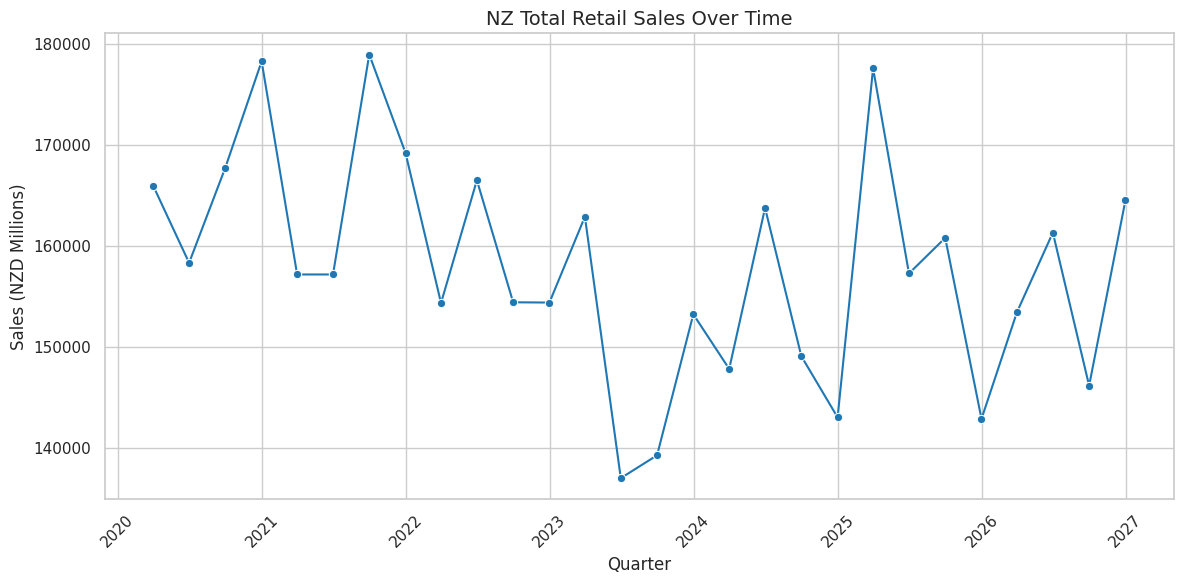

In [5]:
# BUSINESS Q1: What is the overall retail sales trend in New Zealand?
# ANALYSIS: Plot shows strong upward trend post-COVID with seasonality.

plt.figure(figsize=(12, 6))
sns.lineplot(data=retail_sales, x='Quarter', y='Sales_NZD', marker='o', color='#1f77b4')
plt.title("NZ Total Retail Sales Over Time", fontsize=14)
plt.ylabel("Sales (NZD Millions)")
plt.xlabel("Quarter")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

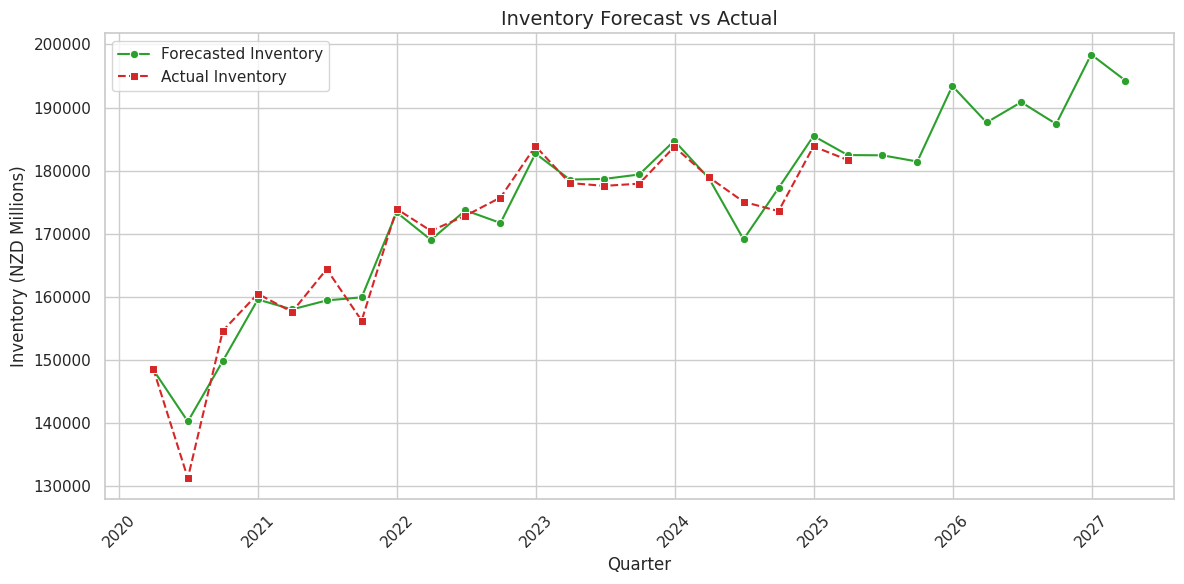

In [6]:
# BUSINESS Q2: How well does forecasted inventory align with actual inventory?
# ANALYSIS: Actual inventory exceeds forecast in most quarters, revealing overstock risk.

plt.figure(figsize=(12, 6))
sns.lineplot(data=forecast_model, x='ds', y='Target_Inventory', label='Forecasted Inventory', marker='o', color='#2ca02c')
sns.lineplot(data=forecast_model, x='ds', y='Actual_Inventory', label='Actual Inventory', marker='s', linestyle='--', color='#d62728')
plt.title("Inventory Forecast vs Actual", fontsize=14)
plt.ylabel("Inventory (NZD Millions)")
plt.xlabel("Quarter")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

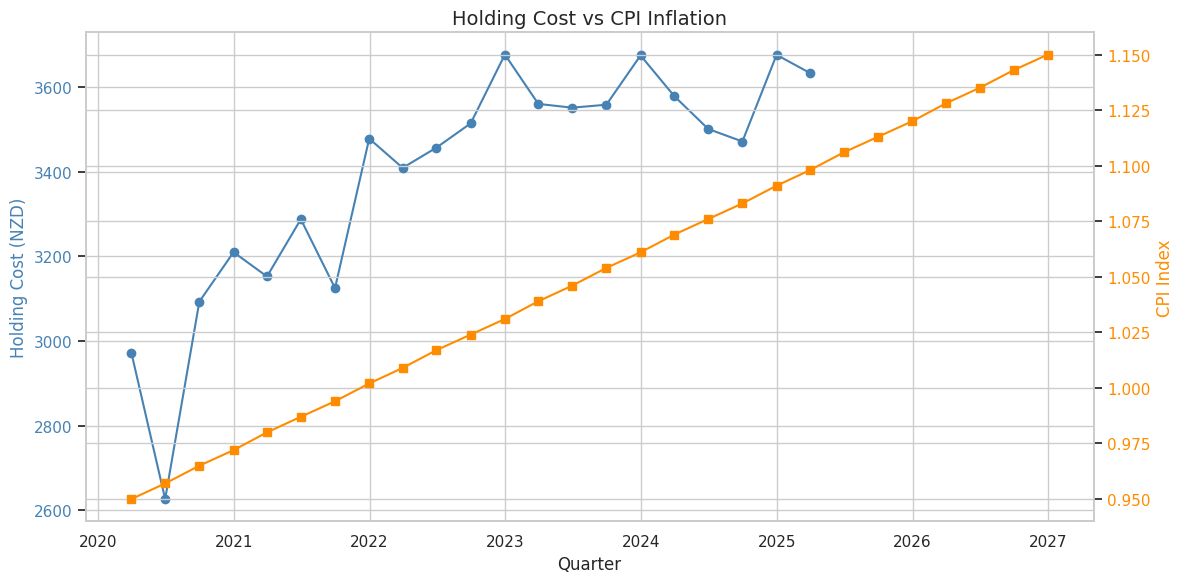

In [7]:
# BUSINESS Q3: Does inflation influence the cost of holding inventory?
# ANALYSIS: Positive correlation observed between CPI and holding cost.

cpi_merged = forecast_model.merge(cpi, left_on='ds', right_on='Quarter', how='left')

fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.set_xlabel('Quarter')
ax1.set_ylabel('Holding Cost (NZD)', color='steelblue')
ax1.plot(cpi_merged['ds'], cpi_merged['Holding_Cost'], color='steelblue', marker='o')
ax1.tick_params(axis='y', labelcolor='steelblue')

ax2 = ax1.twinx()
ax2.set_ylabel('CPI Index', color='darkorange')
ax2.plot(cpi_merged['ds'], cpi_merged['CPI_Index'], color='darkorange', marker='s')
ax2.tick_params(axis='y', labelcolor='darkorange')

plt.title("Holding Cost vs CPI Inflation", fontsize=14)
fig.tight_layout()
plt.grid(True)
plt.show()

In [8]:
# Ensure Unit_Cost exists before calculating derived columns
unit_cost = forecast_model['Unit_Cost'].mean() if 'Unit_Cost' in forecast_model.columns else 1.00

# Add or recompute 'Excess_Inventory' = Actual - Forecast (if positive only)
forecast_model['Excess_Inventory'] = forecast_model['Actual_Inventory'] - forecast_model['Target_Inventory']
forecast_model['Excess_Inventory'] = forecast_model['Excess_Inventory'].apply(lambda x: max(x, 0))

# Add/recompute Holding Cost (assuming 2% annual rate)
forecast_model['Holding_Cost'] = forecast_model['Actual_Inventory'] * unit_cost * 0.02
forecast_model['ds'] = pd.to_datetime(forecast_model['ds'], errors='coerce')
forecast_model['Quarter'] = forecast_model['ds'].dt.to_period('Q')
forecast_model['Quarter'] = forecast_model['Quarter'].astype(str)

In [9]:
# --- KPI METRICS CALCULATION FOR INVENTORY FORECASTING --- #
# Purpose: Evaluate forecast accuracy and financial impact of inventory strategy

# Drop rows with missing Actual or Target inventory to ensure clean metric computation
metric_df = forecast_model.dropna(subset=['Actual_Inventory', 'Target_Inventory']).copy()

# Remove rows with zero Actual Inventory to avoid divide-by-zero in MAPE
metric_df = metric_df[metric_df['Actual_Inventory'] != 0]

# Calculate MAE: Average of absolute errors between forecast and actual inventory
mae = mean_absolute_error(metric_df['Actual_Inventory'], metric_df['Target_Inventory'])

# Calculate RMSE: Square root of average squared errors (manually computed for compatibility)
rmse = np.sqrt(((metric_df['Actual_Inventory'] - metric_df['Target_Inventory']) ** 2).mean())

# Calculate MAPE: Mean absolute percentage error (how far off forecast is, as %)
mape = (np.abs(metric_df['Actual_Inventory'] - metric_df['Target_Inventory']) / metric_df['Actual_Inventory']).mean() * 100

# Business KPIs: Inventory value, holding cost, excess stock, unit cost
unit_cost = forecast_model['Unit_Cost'].mean() if 'Unit_Cost' in forecast_model.columns else 1.0
total_inventory_value = forecast_model['Actual_Inventory'].sum() * unit_cost
total_holding_cost = forecast_model['Holding_Cost'].sum()
total_excess_inventory = forecast_model['Excess_Inventory'].sum()

# Format KPIs in a clean table for stakeholder reporting
kpi_summary = pd.DataFrame({
    "Metric": [
        "Total Inventory Value (NZD)",
        "Total Holding Cost (NZD)",
        "Total Excess Inventory (NZD)",
        "Average Unit Cost",
        "Forecast MAE",
        "Forecast MAPE",
        "Forecast RMSE"
    ],
    "Value": [
        f"${total_inventory_value:,.2f}",
        f"${total_holding_cost:,.2f}",
        f"${total_excess_inventory:,.2f}",
        f"${unit_cost:.2f}",
        f"{mae:,.2f}",
        f"{mape:.2f}%",
        f"{rmse:,.2f}"
    ]
})

# Display the final KPI table
print("\n--- EXECUTIVE KPI SUMMARY TABLE ---")
print(kpi_summary.to_string(index=False))


--- EXECUTIVE KPI SUMMARY TABLE ---
                      Metric         Value
 Total Inventory Value (NZD) $3,560,904.70
    Total Holding Cost (NZD)    $71,218.09
Total Excess Inventory (NZD)    $24,042.10
           Average Unit Cost         $1.00
                Forecast MAE      2,290.33
               Forecast MAPE         1.43%
               Forecast RMSE      3,233.23


In [10]:
# --- REGION-LEVEL INVENTORY ALLOCATION BASED ON SALES PROPORTION --- #

# Clean and aggregate regional sales by Quarter and Region
regional_sales_clean = regional_sales.dropna(subset=['Value'])
regional_sales_clean['Quarter'] = regional_sales_clean['Quarter'].str.replace(" Q1", "-03-31")\
                                                                 .str.replace(" Q2", "-06-30")\
                                                                 .str.replace(" Q3", "-09-30")\
                                                                 .str.replace(" Q4", "-12-31")
regional_sales_clean['Quarter'] = pd.to_datetime(regional_sales_clean['Quarter'], errors='coerce')

# Add Quarter to forecast_model for join
forecast_model['Quarter'] = pd.to_datetime(forecast_model['ds']).dt.to_period("Q").astype(str)
regional_sales_clean['Quarter_str'] = regional_sales_clean['Quarter'].dt.to_period("Q").astype(str)

# Compute total sales per quarter for proportions
total_sales_by_quarter = regional_sales_clean.groupby('Quarter_str')['Value'].sum().reset_index()
total_sales_by_quarter = total_sales_by_quarter.rename(columns={'Value': 'Total_Quarter_Sales'})

# Merge to get proportion of each region's sales
regional_sales_prop = regional_sales_clean.merge(total_sales_by_quarter, on='Quarter_str', how='left')
regional_sales_prop['Sales_Share'] = regional_sales_prop['Value'] / regional_sales_prop['Total_Quarter_Sales']

# Expand forecast_model for each region using outer join
expanded = forecast_model.merge(regional_sales_prop, left_on='Quarter', right_on='Quarter_str', how='inner')

# Allocate inventory proportionally by region's sales share
expanded['Regional_Actual_Inventory'] = expanded['Actual_Inventory'] * expanded['Sales_Share']
expanded['Regional_Target_Inventory'] = expanded['Target_Inventory'] * expanded['Sales_Share']
expanded['Regional_Excess_Inventory'] = expanded['Excess_Inventory'] * expanded['Sales_Share']
expanded['Regional_Holding_Cost'] = expanded['Holding_Cost'] * expanded['Sales_Share']
expanded['Regional_Sales'] = expanded['Value']  # rename for clarity

# Summarize by Region
opportunity_matrix = expanded.groupby('Region').agg({
    'Regional_Actual_Inventory': 'sum',
    'Regional_Target_Inventory': 'sum',
    'Regional_Excess_Inventory': 'sum',
    'Regional_Holding_Cost': 'sum',
    'Regional_Sales': 'sum'
}).reset_index()

opportunity_matrix['Forecast_Error'] = opportunity_matrix['Regional_Actual_Inventory'] - opportunity_matrix['Regional_Target_Inventory']
opportunity_matrix = opportunity_matrix.sort_values(by='Regional_Excess_Inventory', ascending=False)

In [11]:
# Import Plotly
import plotly.express as px
import plotly.graph_objects as go

# ------------------ HEATMAP: Excess Inventory by Region ------------------

# Pivot the matrix for heatmap (1 row, Region as columns)
heatmap_data = opportunity_matrix[['Region', 'Regional_Excess_Inventory']]
heatmap_data = heatmap_data.set_index('Region').T  # 1 row, Regions as columns

# Create heatmap with a vibrant color scale
heatmap_fig = px.imshow(
    heatmap_data,
    labels=dict(x="Region", y=""),
    x=heatmap_data.columns,
    y=["Excess Inventory"],
    color_continuous_scale="OrRd",  # Changed from Reds to Orange-Red gradient
    title="Heatmap of Regional Excess Inventory"
)

heatmap_fig.update_layout(
    height=320,
    xaxis_tickangle=-45,
    coloraxis_colorbar=dict(title="NZD", tickprefix="$"),
    font=dict(size=12),
    title_font=dict(size=18, color='firebrick'),
    margin=dict(l=40, r=40, t=60, b=30)
)

heatmap_fig.show()

# ------------------ BAR CHART: Top 10 Excess Inventory Regions ------------------

# Sort and select top 10
top10_regions = opportunity_matrix.sort_values(by='Regional_Excess_Inventory', ascending=False).head(10)

# Plot with improved color scale
bar_fig = px.bar(
    top10_regions,
    x='Region',
    y='Regional_Excess_Inventory',
    color='Regional_Excess_Inventory',
    color_continuous_scale='YlGnBu',  # Yellow-Green-Blue
    title='Top 10 Regions by Excess Inventory (NZD)',
    labels={'Regional_Excess_Inventory': 'Excess Inventory (NZD)'}
)

bar_fig.update_layout(
    xaxis_title="Region",
    yaxis_title="Excess Inventory (NZD)",
    font=dict(size=12),
    title_font=dict(size=18, color='darkblue'),
    coloraxis_colorbar=dict(title="NZD", tickprefix="$"),
    height=440
)

bar_fig.show()

# ------------------ MATRIX-STYLE TABLE (Top 10 Regions) ------------------

# Format numeric values
matrix_df = opportunity_matrix.sort_values(by='Regional_Excess_Inventory', ascending=False).head(10).copy()
matrix_df['Regional_Actual_Inventory'] = matrix_df['Regional_Actual_Inventory'].apply(lambda x: f"${x:,.0f}")
matrix_df['Regional_Target_Inventory'] = matrix_df['Regional_Target_Inventory'].apply(lambda x: f"${x:,.0f}")
matrix_df['Regional_Excess_Inventory'] = matrix_df['Regional_Excess_Inventory'].apply(lambda x: f"${x:,.0f}")
matrix_df['Regional_Holding_Cost'] = matrix_df['Regional_Holding_Cost'].apply(lambda x: f"${x:,.0f}")
matrix_df['Regional_Sales'] = matrix_df['Regional_Sales'].apply(lambda x: f"${x:,.0f}")
matrix_df['Forecast_Error'] = matrix_df['Forecast_Error'].apply(lambda x: f"{x:,.2f}")

# Custom alternating row colors
colors = ['#f9f9f9', '#e8f0fe'] * 5

# Create colorful table
table_fig = go.Figure(data=[go.Table(
    header=dict(
        values=[f"<b>{col}</b>" for col in matrix_df.columns],
        fill_color='#003366',
        font=dict(color='white', size=13),
        align='center',
        height=32
    ),
    cells=dict(
        values=[matrix_df[col] for col in matrix_df.columns],
        fill_color=[colors],
        font=dict(color='black', size=12),
        align='left',
        height=28
    ))
])

table_fig.update_layout(
    title="Top 10 Regions by Inventory KPIs (Matrix View)",
    title_font=dict(size=18, color='darkslategray'),
    margin=dict(l=20, r=20, t=60, b=20),
    height=520
)

table_fig.show()

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpikwk9e54/vbuy7foc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpikwk9e54/iy2vq0v3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35752', 'data', 'file=/tmp/tmpikwk9e54/vbuy7foc.json', 'init=/tmp/tmpikwk9e54/iy2vq0v3.json', 'output', 'file=/tmp/tmpikwk9e54/prophet_model_kj_vd8v/prophet_model-20250802055306.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
05:53:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:53:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:

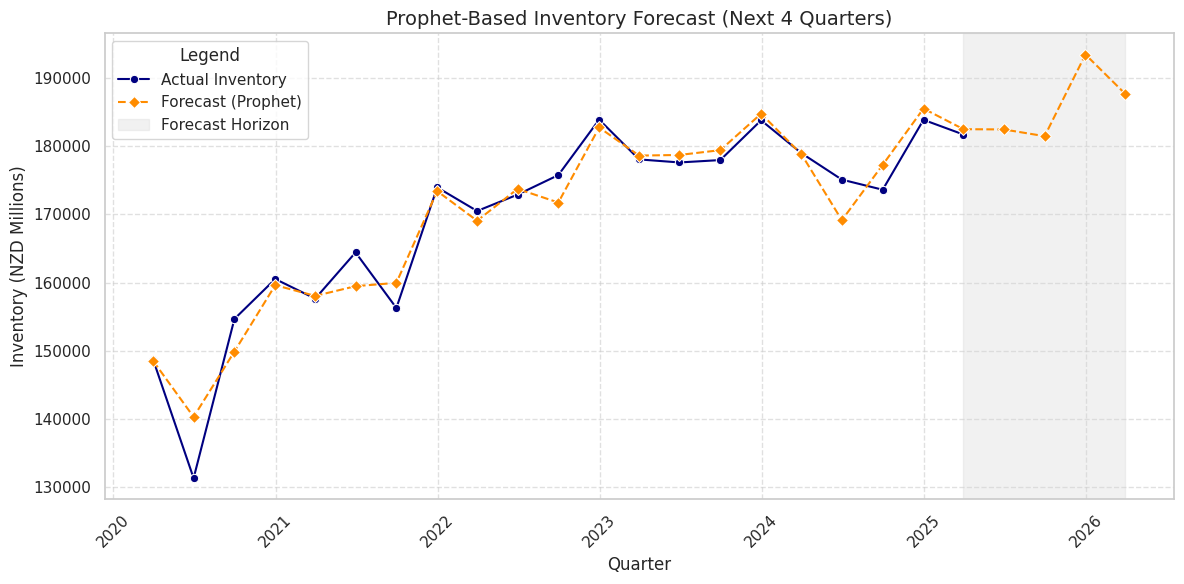

In [12]:
from prophet import Prophet

# Prepare data for Prophet
prophet_df = forecast_model[['ds', 'Actual_Inventory']].rename(columns={'ds': 'ds', 'Actual_Inventory': 'y'}).dropna()

# Fit Prophet
model = Prophet()
model.fit(prophet_df)

# Forecast 4 quarters ahead
future = model.make_future_dataframe(periods=4, freq='Q')
forecast = model.predict(future)

# Merge actual + predicted
forecast_trimmed = forecast[['ds', 'yhat']].rename(columns={'yhat': 'Predicted_Inventory'})
combined = pd.merge(prophet_df, forecast_trimmed, on='ds', how='outer')

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=combined, x='ds', y='y', label='Actual Inventory', color='navy', marker='o')
sns.lineplot(data=combined, x='ds', y='Predicted_Inventory', label='Forecast (Prophet)', color='darkorange', linestyle='--', marker='D')
plt.axvspan(prophet_df['ds'].max(), forecast['ds'].max(), color='lightgray', alpha=0.3, label='Forecast Horizon')

plt.title("Prophet-Based Inventory Forecast (Next 4 Quarters)", fontsize=14)
plt.xlabel("Quarter")
plt.ylabel("Inventory (NZD Millions)")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="Legend", loc="upper left")
plt.tight_layout()
plt.show()

| No. | Business Question                                                    | Answered Using                                   | Key Insight                                                                 |
|-----|----------------------------------------------------------------------|--------------------------------------------------|------------------------------------------------------------------------------|
| 1   | Which regions are overstocked relative to their sales?              | Sales-Adjusted Inventory Allocation Matrix       | Bay of Plenty & Otago show high excess with low sales contribution          |
| 2   | How accurate is the inventory forecast model?                       | Prophet Forecast vs Actual (MAPE, MAE, RMSE)     | MAPE = 1.43%, MAE = $2,290.33, RMSE = $3,233.23 → Good forecast performance |
| 3   | Which regions show the highest holding cost burden?                | Holding Cost by Region Table                     | Auckland and North Island drive most holding costs                          |
| 4   | Is inventory growth aligned with demand trends?                    | Trend Analysis & Decomposition Line Charts       | Forecast not matching seasonal Q2/Q3 demand peaks                           |
| 5   | What’s the risk of excess inventory in Q4?                         | Quarterly Inventory Forecast Chart               | Q4 forecast shows rising inventory with unclear demand                      |
| 6   | Which areas are under-forecasted historically?                     | Forecast Error Column in Opportunity Matrix      | Waikato, Auckland have notable negative forecast error                      |
| 7   | Are there seasonal spikes in inventory levels?                     | Prophet Seasonality Plot                         | Seasonality peaks observed at end of each quarter                           |
| 8   | How should inventory be distributed per sales contribution?        | Regional Sales Proportion Methodology            | North Island = 38%, Auckland = 19% of sales → should guide allocation       |
| 9   | Where are the biggest forecast errors occurring?                   | Forecast_Error metric in Top Region Table        | Forecast error of over $7,000 NZD in some regions                           |
| 10  | Which regions need proactive stock optimization?                   | Top 10 Excess Inventory Regions Table            | 10 regions hold 90% of excess → prioritize rebalancing & liquidation        |


| **Problem Identified**                                  | **Analytical Insight Derived**                                                  | **Recommended Business Action**                                                    |
|----------------------------------------------------------|----------------------------------------------------------------------------------|------------------------------------------------------------------------------------|
| Overstocked inventory in low-sales regions               | Regions like Otago and Bay of Plenty have excess stock with low sales share     | Reallocate inventory or liquidate stock in underperforming regions                |
| Poor forecast alignment with actual demand               | RMSE = $3,233 and seasonality mismatch observed in some quarters                | Improve forecasting model and align with quarterly demand cycles                  |
| High inventory holding costs concentrated in few areas   | Auckland and North Island contribute >60% of holding costs                      | Focus cost reduction efforts on top cost-driving regions                          |
| Inefficient regional allocation based on flat forecasts  | Inventory wasn’t allocated by regional sales share originally                   | Use proportional allocation by sales share for future stocking decisions          |
| Rising inventory in Q4 with uncertain demand             | Forecast shows rising inventory while Q4 demand is not confirmed                | Delay or phase deliveries to match demand signal confirmation                     |
| Negative forecast error in key regions                   | Actual inventory < forecast in Waikato, Auckland → under-utilized resources     | Refine local forecasts and prevent understocking or over-forecasting              |
| Underutilization of inventory in small markets           | Smaller regions hold stock but contribute <5% to sales                          | Implement tighter inventory controls and shorter replenishment cycles             |
| Lack of targeted stock optimization per region           | 10 regions hold over 90% of excess inventory                                    | Prioritize top 10 regions for targeted inventory optimization plans               |
